<a href="http://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07C_XTN%20-%20Text%20Classification%20Deep%20Learning%20Sequential%20Models%20Bidirectional%20GRUs%20with%20Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk

nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 7.5 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Load and View Dataset

In [ ]:
import pandas as pd
import numpy as np

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [ ]:
## Start from this Cell
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import re
from pandas import read_excel
dataset=pd.read_csv('/content/drive/MyDrive/nlp bio informatics/final_rediology_data.csv')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# take a peek at the data
dataset.head()

,fulltext,label
0,The cardiomediastinal silhouette appears irreg...,abnormal
1,Stable cardiomegaly. Improved aeration in the ...,abnormal
2,2 views of the chest demonstrate sternotomy a...,abnormal
3,"The heart, pulmonary and mediastinum are with...",abnormal
4,Stable appearance of aortic valve prosthesis. ...,abnormal


In [ ]:
dataset.describe()

,fulltext,label
count,3927,3955
unique,3159,2
top,The heart and lungs have in the interval. Bo...,abnormal
freq,53,2564


In [ ]:
dataset.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

,fulltext,label
0,The cardiomediastinal silhouette appears irreg...,abnormal
1,Stable cardiomegaly. Improved aeration in the ...,abnormal
2,2 views of the chest demonstrate sternotomy a...,abnormal
3,"The heart, pulmonary and mediastinum are with...",abnormal
4,Stable appearance of aortic valve prosthesis. ...,abnormal
...,...,...
3950,Clear lungs bilaterally. Normal cardiac contou...,normal
3951,Heart size normal. Lungs clear. Stable 5 mm ca...,abnormal
3952,The cardiac and mediastinal silhouettes are un...,abnormal
3953,Heart size normal. Lungs are clear. are norma...,normal


In [ ]:
dataset.dropna(inplace=True)
dataset.drop_duplicates(inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2, random_state=0)

In [ ]:
from nltk.parse.util import TestGrammar
# build train and test datasets
reviews = dataset['fulltext'].values
sentiments = dataset['label'].values

train_reviews = train['fulltext'].values
train_sentiments = train['label'].values

test_reviews = test['fulltext'].values
test_sentiments = test['label'].values

In [ ]:
# train_reviews = X_train
# train_sentiments = y_train

# test_reviews = X_test
# test_sentiments = y_train

# Basic Data Pre-processing

In [ ]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for sentence in range(0, len(train)):
    processed_feature = re.sub(r'\W', ' ', str(train[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()
    norm_docs.append(processed_feature)

  return norm_docs

In [ ]:
features = train.iloc[:, 0].values
labels = train.iloc[:, -1].values

In [ ]:
def pre_process_corpus():
  processed_features = []

  for sentence in range(0, len(features)):
      # Remove all the special characters
      processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

      # remove all single characters
      processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

      # Remove single characters from the start
      processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)

      # Substituting multiple spaces with single space
      processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

      # Removing prefixed 'b'
      processed_feature = re.sub(r'^b\s+', '', processed_feature)

      # Converting to Lowercase
      processed_feature = processed_feature.lower()

      processed_features.append(processed_feature)
  return processed_features

In [ ]:
%%time

norm_train_reviews = pre_process_corpus()
# norm_test_reviews = pre_process_corpus(test_reviews)

CPU times: user 118 ms, sys: 2.27 ms, total: 120 ms
Wall time: 121 ms


In [ ]:
features1 = test.iloc[:, 0].values
labels1 = test.iloc[:, -1].values

In [ ]:
def pre_process_corpus1():
  processed_features = []

  for sentence in range(0, len(features1)):
      # Remove all the special characters
      processed_feature = re.sub(r'\W', ' ', str(features1[sentence]))

      # remove all single characters
      processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

      # Remove single characters from the start
      processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)

      # Substituting multiple spaces with single space
      processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

      # Removing prefixed 'b'
      processed_feature = re.sub(r'^b\s+', '', processed_feature)

      # Converting to Lowercase
      processed_feature = processed_feature.lower()

      processed_features.append(processed_feature)
  return processed_features

In [ ]:
norm_test_reviews = pre_process_corpus1()

In [ ]:
norm_test_reviews

['mediastinal contours are normal blunting of the left costophrenic increased interstitial opacities there is no pneumothorax or large pleural effusion diffuse interstitial lung disease with pleural effusion ',
 'the lungs appear clear the heart and pulmonary are normal mediastinal contours are normal surgical clips are identified in the mediastinum pleural spaces are clear soft tissue previously noted along the right lateral chest wall has resolved no acute cardiopulmonary disease',
 'the lungs appear clear the heart and pulmonary are normal mediastinal contours are normal the pleural spaces are clear no acute cardiopulmonary disease ',
 'the cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size the lungs are mildly hypoinflated but grossly clear of focal airspace disease pneumothorax or pleural effusion there are mild degenerative endplate changes in the thoracic spine there are no acute bony findings no acute cardiopulmonary findings ',
 'there is s

## Data Preprocessing and formatting

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [ ]:
import keras

t = keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [ ]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('hypertrophy', 1893), ('<PAD>', 0), 1)

In [ ]:
train_sequences = t.texts_to_sequences(train_reviews)
test_sequences = t.texts_to_sequences(test_reviews)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=1894
Number of Documents=2535


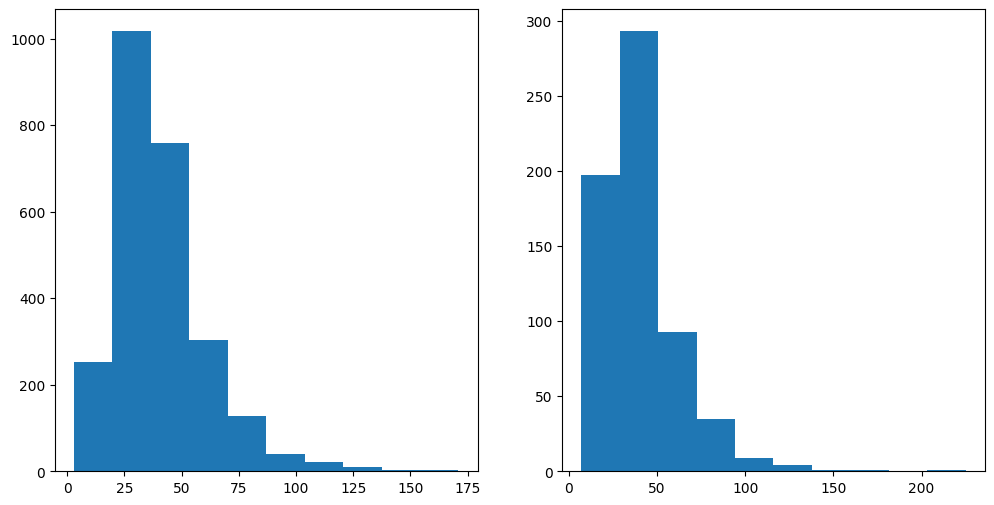

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

### Sequence Normalization

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [ ]:
!pip install keras


In [ ]:
MAX_SEQUENCE_LENGTH = 1000

In [ ]:
from keras.utils import pad_sequences
from keras.utils import pad_sequences




# pad dataset to a maximum review length in words
X_train = keras.utils.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = keras.utils.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((2535, 1000), (634, 1000))

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [ ]:
y_train = le.fit_transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
np.count_nonzero(y_train == 0)


1993

In [ ]:
y_test

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,

In [ ]:
VOCAB_SIZE = len(t.word_index)

# Bi-directional GRU + Attention Model

## Build Model Architecture

### Attention Layer

Attention Layer focuses on attending to the most important words. We sent all the states from our GRU model into the attention model.

![](https://i.imgur.com/vbGl6Vl.png)

The attention layer produces a context vector

![](https://i.imgur.com/nZ71MVd.png)

![](https://i.imgur.com/00KyS2e.png)

In [ ]:
import tensorflow
tensorflow.__version__

'2.14.0'

In [ ]:
from tensorflow.keras.layers import Layer, InputSpec
from keras import backend as K


class AttentionLayer(Layer):

    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        """

        self.supports_masking = True
        self.init = keras.initializers.get('glorot_uniform')

        self.W_regularizer = keras.regularizers.get(W_regularizer)
        self.b_regularizer = keras.regularizers.get(b_regularizer)

        self.W_constraint = keras.constraints.get(W_constraint)
        self.b_constraint = keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)


    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True


    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None


    def call(self, x, mask=None):
        # TF backend doesn't support it
        # eij = K.dot(x, self.W)
        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a

        return K.sum(weighted_input, axis=1)


    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### Bi-directional GRUs

![](https://i.imgur.com/PuTHi2C.png)

![](https://i.imgur.com/ewTg3gB.png)

![](https://i.imgur.com/oaBYGeu.png)

In [ ]:
import tensorflow as tf

In [ ]:
EMBEDDING_DIM = 400 # dimension for dense embeddings for each token
GRU_DIM = 128 # total LSTM units

inp = keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
x = keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(inp)
x = keras.layers.Bidirectional(keras.layers.LSTM(GRU_DIM, return_sequences=True))(x)
x = AttentionLayer(MAX_SEQUENCE_LENGTH)(x)
x = keras.layers.Dense(GRU_DIM*2, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.Dense(GRU_DIM, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)

outp = keras.layers.Dense(1, activation='sigmoid')(x)
# initialize the model
model = keras.models.Model(inputs=inp, outputs=outp)

# make the model parallel
# model = multi_gpu_model(model, gpus=2)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding_2 (Embedding)     (None, 1000, 400)         757600    
                                                                 
 bidirectional (Bidirection  (None, 1000, 256)         541696    
 al)                                                             
                                                                 
 attention_layer (Attention  (None, 256)               1256      
 Layer)                                                          
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [ ]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

## Train Model

In [ ]:
batch_size = 32
model.fit(X_train, y_train, epochs=10, batch_size=batch_size,
          shuffle=True, verbose=1)

Epoch 1/10
80/80 [==============================] - 27s 200ms/step - loss: 0.5310 - accuracy: 0.7862
Epoch 2/10
80/80 [==============================] - 13s 161ms/step - loss: 0.4762 - accuracy: 0.7787
Epoch 3/10
80/80 [==============================] - 11s 133ms/step - loss: 0.4045 - accuracy: 0.7799
Epoch 4/10
80/80 [==============================] - 8s 104ms/step - loss: 0.3769 - accuracy: 0.7732
Epoch 5/10
80/80 [==============================] - 11s 137ms/step - loss: 0.3773 - accuracy: 0.7744
Epoch 6/10
80/80 [==============================] - 8s 100ms/step - loss: 0.4179 - accuracy: 0.7862
Epoch 7/10
80/80 [==============================] - 7s 93ms/step - loss: 0.4104 - accuracy: 0.7870
Epoch 8/10
80/80 [==============================] - 7s 92ms/step - loss: 0.2373 - accuracy: 0.8978
Epoch 9/10
80/80 [==============================] - 7s 90ms/step - loss: 0.1354 - accuracy: 0.9582
Epoch 10/10
80/80 [==============================] - 7s 91ms/step - loss: 0.1272 - accuracy: 0.9613

## Evaluate Model Performance

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

20/20 [==============================] - 1s 33ms/step - loss: 0.1970 - accuracy: 0.9416
Accuracy: 94.16%


In [ ]:
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]


20/20 [==============================] - 1s 30ms/step


In [ ]:
predictions = ['normal' if item == 1 else 'abnormal' for item in predictions]
predictions

['abnormal',
 'abnormal',
 'normal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'normal',
 'abnormal',
 'abnormal',
 'normal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'normal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'normal',
 'abnormal',
 'normal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'normal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'normal',
 'abnormal',
 'normal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'normal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'normal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'normal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'normal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',
 'abnormal',

In [ ]:
test_sentiments

array(['abnormal', 'abnormal', 'normal', 'abnormal', 'abnormal',
       'abnormal', 'abnormal', 'abnormal', 'abnormal', 'normal',
       'abnormal', 'abnormal', 'normal', 'abnormal', 'abnormal',
       'abnormal', 'abnormal', 'abnormal', 'abnormal', 'abnormal',
       'abnormal', 'abnormal', 'abnormal', 'normal', 'abnormal', 'normal',
       'abnormal', 'abnormal', 'abnormal', 'abnormal', 'abnormal',
       'abnormal', 'normal', 'abnormal', 'abnormal', 'normal', 'abnormal',
       'normal', 'abnormal', 'abnormal', 'abnormal', 'abnormal',
       'abnormal', 'abnormal', 'abnormal', 'normal', 'abnormal', 'normal',
       'abnormal', 'abnormal', 'abnormal', 'abnormal', 'abnormal',
       'abnormal', 'abnormal', 'abnormal', 'abnormal', 'abnormal',
       'abnormal', 'abnormal', 'abnormal', 'abnormal', 'normal', 'normal',
       'abnormal', 'abnormal', 'abnormal', 'abnormal', 'abnormal',
       'abnormal', 'abnormal', 'abnormal', 'abnormal', 'normal',
       'abnormal', 'abnormal', 'normal',

In [ ]:
labels = ['normal', 'abnormal']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    abnormal       0.94      0.98      0.96       487
      normal       0.94      0.80      0.86       147

    accuracy                           0.94       634
   macro avg       0.94      0.89      0.91       634
weighted avg       0.94      0.94      0.94       634



,normal,abnormal
normal,479,8
abnormal,29,118


In [ ]:
print(confusion_matrix(test_sentiments, predictions))


[[479   8]
 [ 29 118]]


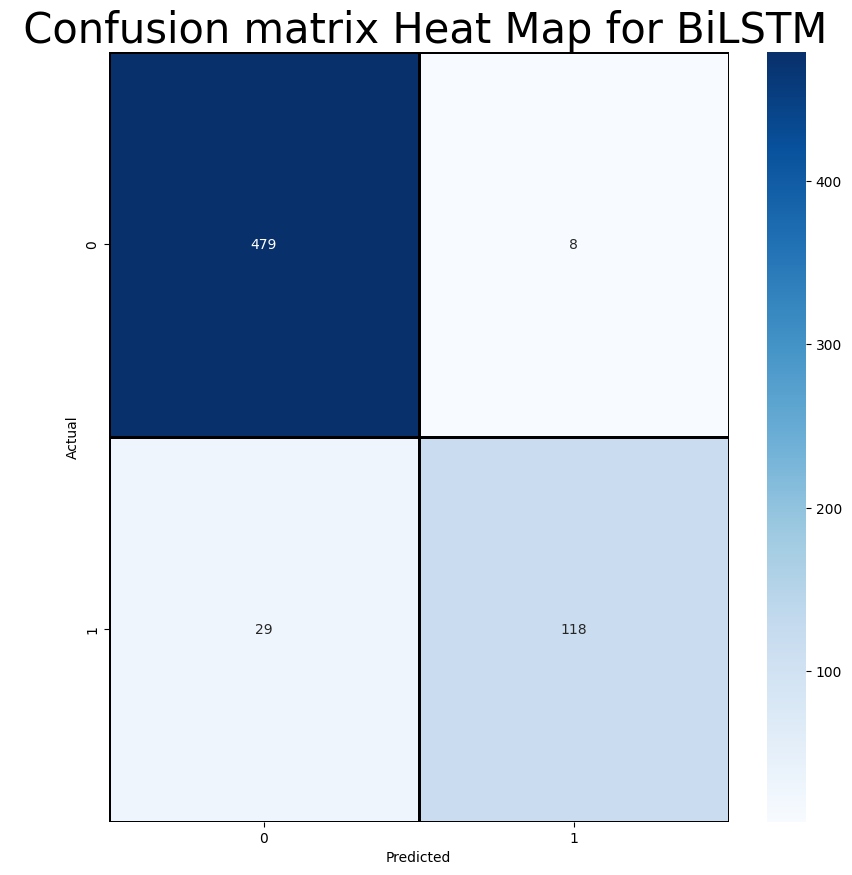

In [ ]:
import seaborn as sn
from sklearn import metrics
cm = metrics.confusion_matrix(test_sentiments, predictions)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues",
            linecolor = 'black',
            linewidth = 1,
            annot = True,
            fmt='',
            )
plt.xlabel("Predicted")
sn.set(font_scale=2.5)

plt.ylabel("Actual")
plt.title(" Confusion matrix Heat Map for BiLSTM")

cm = metrics.confusion_matrix(test_sentiments, predictions)
sn.set(font_scale=2.5)